<a href="https://colab.research.google.com/github/tryambak2019/ReinforcementLearning_StockTrading/blob/master/Reinforcement_Learning_RNN_Transformer_AttentionLSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Trading Bot with Reinforcement Learning

This code compares RNN, Transformer, Attention LSTM, and Weighted Attention performances for deep learning Reinforcement Policies in trading S&P500 stocks

**Disclaimer : This work is only for education and research purpose and authors do not take any commercial liability for its accuracy.**

This work is part of AISC Reinforcement Learning Workshop in October 2019.

Authors:

* Tryambak Kaushik
* Eric Djona Fegnem
* Vladimir Blagojevic

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

%matplotlib inline
import matplotlib.pyplot as plt

import os
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Report warnings as errors
# import warnings
# warnings.filterwarnings('error')

In [0]:
torch.manual_seed(51)

Create a sub-directory to store downloaded stock data as pickle files

---


In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/AISC/RL')

my_dir = 'stock_dfs'
if not os.path.exists(my_dir):
    os.makedirs(my_dir)

!pwd

/content/gdrive/My Drive/Colab Notebooks/AISC/RL


##Download, Store or load Stock Data

###Download Stock Data

In [0]:
!pip install yfinance
import yfinance as yf

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1426 entries, 2014-01-02 to 2019-08-30
Data columns (total 6 columns):
Open         1426 non-null float64
High         1426 non-null float64
Low          1426 non-null float64
Close        1426 non-null float64
Adj Close    1426 non-null float64
Volume       1426 non-null int64
dtypes: float64(5), int64(1)
memory usage: 78.0 KB


Text(0.5, 1.0, 'Stock Data - Open Price')

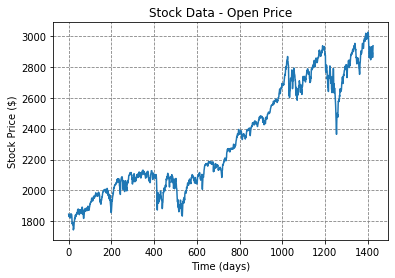

In [0]:
stock_data = yf.download("^GSPC", start="2014-01-01", end="2019-08-31",
                   group_by="ticker")

stock_data.info()

plt.plot(range(0, len(stock_data)), stock_data['Open'])
plt.xlabel('Time (days)')
plt.ylabel('Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Stock Data - Open Price')

###Split data in train and test samples

train data is
> from 2014-01-01 to 2018-08-31

test data is 
> from 2018-09-01 to 2019-08-31

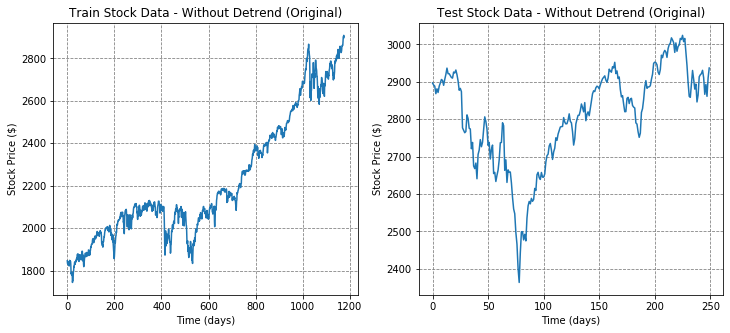

In [0]:
train = stock_data["2014-01-01":"2018-08-31"].copy()
test = stock_data["2018-09-01":"2019-08-31"].copy()

# print(train.info())
# print(test.info())

plt.figure(1, figsize=(12,5))
sp5_tr = plt.subplot(121)
sp5_tt = plt.subplot(122)

sp5_tr.plot(range(0, len(train)), train['Open'])
sp5_tr.set_xlabel('Time (days)')
sp5_tr.set_ylabel('Stock Price ($)')
sp5_tr.grid(color='gray', linestyle='dashed')
sp5_tr.title.set_text('Train Stock Data - Without Detrend (Original)')

sp5_tt.plot(range(0, len(test)), test['Open'])
sp5_tt.set_xlabel('Time (days)')
sp5_tt.set_ylabel('Stock Price ($)')
sp5_tt.grid(color='gray', linestyle='dashed')
sp5_tt.title.set_text('Test Stock Data - Without Detrend (Original)')

Text(0.5, 1.0, 'Train Stock Data')

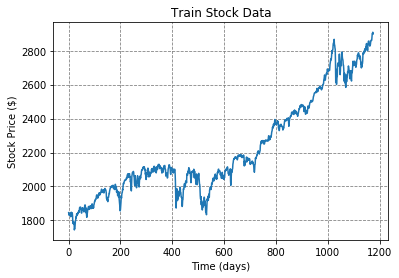

In [0]:
sp5_stock = train[:].copy()
sp5_open_orig = train["Open"].values
sp5_close_close = train["Close"].values

plt.plot(range(0, len(sp5_open_orig)), sp5_open_orig)
plt.xlabel('Time (days)')
plt.ylabel('Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Train Stock Data - Without Setrend (Orignal)')

In [0]:
sp5_stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,1845.859985,1845.859985,1827.739990,1831.979980,1831.979980,3080600000
2014-01-03,1833.209961,1838.239990,1829.130005,1831.369995,1831.369995,2774270000
2014-01-06,1832.310059,1837.160034,1823.729980,1826.770020,1826.770020,3294850000
2014-01-07,1828.709961,1840.099976,1828.709961,1837.880005,1837.880005,3511750000
2014-01-08,1837.900024,1840.020020,1831.400024,1837.489990,1837.489990,3652140000


###De-trend Stock Data

Use scipy to de-trend stock data

In [0]:
# !pip install scipy

Text(0.5, 1.0, 'Train Stock Data')

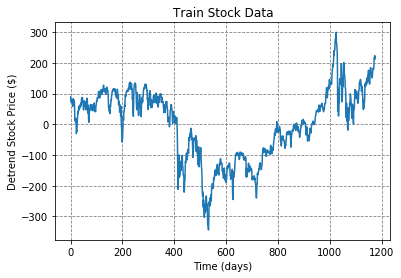

In [0]:
from scipy import signal

sp5_open = signal.detrend(sp5_open_orig)
sp5_close = signal.detrend(sp5_close_orig)

plt.plot(range(0,len(sp5_open)), sp5_open)
plt.xlabel('Time (days)')
plt.ylabel('Detrend Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Train Stock Data - Detrend')

Add 400 to all values to move all values to positive quadrant

Text(0.5, 1.0, 'Train Stock Data')

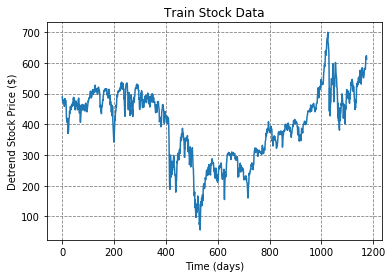

In [0]:
sp5_open += 400
sp5_close += 400

plt.plot(range(0,len(sp5_open)), sp5_open)
plt.xlabel('Time (days)')
plt.ylabel('Detrend Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Train Stock Data - De-trend and Scaled')

###Save the transformed data



In [0]:
import pickle
with open(my_dir + "/" +"sp5openclose.pkl", "wb+") as f:
    pickle.dump({"stock_d": stock_data, "train_d" : train, "test_d" : test,
                 "sp5o": sp5_open, "sp5c": sp5_close}, f)
f.close()

###Load the transformed data if already saved



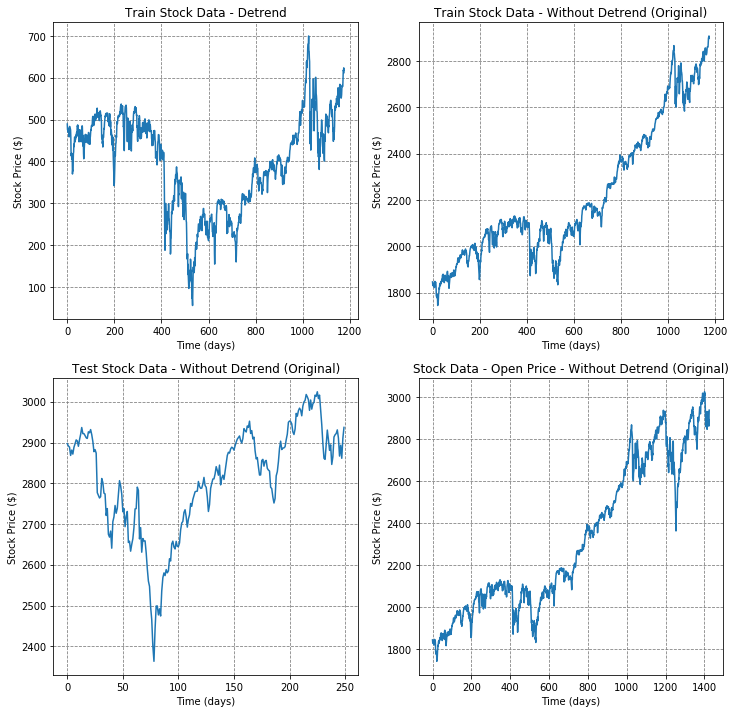

In [0]:
# import pickle
# with open(my_dir + "/" + "sp5openclose.pkl", "rb") as f:
#     d = pickle.load(f)
# f.close ()

# stock_data = d["stock_d"]
# sp5_open = d["sp5o"]
# sp5_close = d["sp5c"]

# train = d['train_d']
# test = d['test_d']

# plt.figure(1, figsize=(12,12))
# sp5_tr1 = plt.subplot(221)
# sp5_tr2 = plt.subplot(222)
# sp5_tt = plt.subplot(223)
# sp5_st = plt.subplot(224)

# sp5_tr1.plot(range(0,len(sp5_open)), sp5_open)
# sp5_tr1.set_xlabel('Time (days)')
# sp5_tr1.set_ylabel('Stock Price ($)')
# sp5_tr1.grid(color='gray', linestyle='dashed')
# sp5_tr1.title.set_text('Train Stock Data - Detrend')

# sp5_tr2.plot(range(0,len(train)), train['Open'])
# sp5_tr2.set_xlabel('Time (days)')
# sp5_tr2.set_ylabel('Stock Price ($)')
# sp5_tr2.grid(color='gray', linestyle='dashed')
# sp5_tr2.title.set_text('Train Stock Data - Without Detrend (Original)')

# sp5_tt.plot(range(0, len(test)), test['Open'])
# sp5_tt.set_xlabel('Time (days)')
# sp5_tt.set_ylabel('Stock Price ($)')
# sp5_tt.grid(color='gray', linestyle='dashed')
# sp5_tt.title.set_text('Test Stock Data - Without Detrend (Original)')

# sp5_st.plot(range(0, len(stock_data)), stock_data['Open'])
# sp5_st.set_xlabel('Time (days)')
# sp5_st.set_ylabel('Stock Price ($)')
# sp5_st.grid(color='gray', linestyle='dashed')
# sp5_st.title.set_text('Stock Data - Open Price - Without Detrend (Original)')

##Implement Reinforcement Learning

### Define Environment for RL Environment

Use Trading templates from OpenAI gym modules

---



*   action space :
                   0 sell sp500,
                   1 buy sp500,
                   2 do nothing,
                   quantity. eg. [0, 100] 

*   obs space    : 
                   sp500 shares [0], 
                   cash in bank [1], 
                   today sp500 open [2],
                   portfolio value [3],
                   5 day window [4]

*   Buys and sells attract a 10% brokerage fee

In [0]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, 
                 series_length=208, starting_point=1, 
                 randomize_cash_std=0, starting_shares_mean=0.,
                 randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(5)).cuda()
        
        self.starting_cash = max(int(np.random.normal(
            self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(
            self.starting_shares_mean, self.randomize_shares_std)), 0.)
 
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = sp5_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
     
        self.max_stride = max_stride
        self.stride = self.max_stride # Static for current case, can change
        
        self.done = False

        self.inaction_penalty = inaction_penalty
    
    def price_ratio(self):
      return (sp5_open[self.cur_timestep]/
                            sp5_close[self.cur_timestep])

    def portfolio_value(self):
        return (self.state[0] * sp5_close[self.cur_timestep]) + self.state[1]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return sp5_open[step]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return sp5_open[0]
        sp55 = sp5_open[step-5:step].mean()
        return sp55
    
    def step(self, action):

        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        self.state[0] = max(int(np.random.normal(
            self.starting_shares_mean, self.randomize_shares_std)), 0.)
 
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = sp5_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        
        st_val = self.starting_portfolio_value

        if cur_timestep >= self.starting_point + (
            self.series_length * self.stride):

            new_state = [self.state[0], self.state[1],
                         self.next_opening_price(), \
                        cur_value, self.five_day_window()]
            self.state = new_state
            bonus = 0.
            return (new_state, cur_value + bonus + gain,
             True, { "msg": "done"}), st_val, gain

        if action[0] == 2:
            new_state = [self.state[0], self.state[1],
                         self.next_opening_price(), \
                    cur_value, self.five_day_window()]

            self.state = new_state
            retval = new_state, -self.inaction_penalty - ts_left + gain, \
             False, { "msg": "nothing" }

                            
        if action[0] == 1:
            if action[1] * sp5_open[cur_timestep] > self.state[1]:
                new_state = [self.state[0], self.state[1],
                             self.next_opening_price(), cur_value,
                             self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left + gain/2, True, \
                 { "msg": "bankrupted self"}

            else:
                sp5_shares = self.state[0] + action[1]
                # 1.1 means extra 10% cash charged as brokerage fees
                cash_spent = action[1] * sp5_open[cur_timestep] * 1.1
                new_state = [sp5_shares, self.state[1] - cash_spent, 
                             self.next_opening_price(), \
                       cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty - ts_left + gain, \
                 False, { "msg": "bought sp500"}

                    
        if action[0] == 0:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], 
                             self.next_opening_price(), \
                        cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left + gain/2, True,\
                 { "msg": "sold more than have"}

            else:
                sp5_shares = self.state[0] - action[1]
                # 0.9 means 10% cash chargeded as brokerage fees
                cash_gained = action[1] * sp5_open[cur_timestep] * 0.9
                new_state = [ sp5_shares, 
                             self.state[1] + cash_gained, 
                             self.next_opening_price(), \
                       cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty - ts_left + gain,\
                 False, { "msg": "sold sp500"}


        self.cur_timestep += self.stride

        return retval, st_val, gain
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(5)).cuda()
        self.starting_cash = max(int(np.random.normal(
            self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point

        self.state[0] = max(int(np.random.normal(
            self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = self.starting_cash
        self.state[2] = sp5_open[self.cur_timestep]

        self.starting_portfolio_value = self.portfolio_value()
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()      
        self.done = False
        return self.state

###Define RNN Policy for RL Environment

Policy is used determine next action.

Or in other words, policy is agent's way of behaving at a given time

In [0]:
class RNNPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(5, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.zeros(2,1,32).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        
        self.action_head = nn.Linear(31, 3)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

#Optional reset_hidden can be commented
    def reset_hidden(self):
        self.hidden_state = torch.zeros(2,1,32).cuda()
        
    def forward(self, x):
        x = torch.tensor(x).cuda()
        
        x = torch.sigmoid(self.input_layer(x))
        
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), 
                                        self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))

        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        # if policy asks to sell and number of shares are less than 1
        # than do nothing, i.e., action = 2
        if action == 0 and env.state[0] < 1:
          action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

###Define AttnLSTM and WeightedLSTM Policy for RL Environment

Same model deifinition is used for AttnLSTM and WeigtedLSTM

In [0]:
class softAttn(nn.Module):
  def __init__(self, input_size):
    super(softAttn, self).__init__()
    self.linear1 = nn.Linear(input_size, input_size)

  def forward(self, x):
    x = torch.tanh(self.linear1(x))
    return F.softmax(x, dim = -1) * x
    
class AttnLSTM(nn.Module):
  def __init__(self, input_size):
    super(AttnLSTM, self).__init__()

    self.linear1 = nn.Linear(input_size, input_size)
    self.linear2 = nn.Linear(input_size, input_size)
    self.linear3 = nn.Linear(input_size, input_size)
    self.lstm = nn.LSTM(input_size, input_size)

  def forward(self, x, h, s):
    out = self.linear3(torch.tanh(self.linear1(s) + self.linear2(h)))
    out = F.softmax(out, dim = -1)
    out, (h, s) = self.lstm(out, (h, s))

    return x * out

class AttnLSTMPolicy(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    
    self.input_size = input_size
    self.hidden_state =  torch.FloatTensor(
        torch.zeros(2,1,1,input_size)).to(device)
    self.softAttn = softAttn(input_size)
    self.lstm1 = AttnLSTM(input_size)
    self.lstm2 = nn.LSTM(input_size, input_size)

    self.fc = nn.Linear(input_size, output_size)

    self.action_head = nn.Linear(output_size, 3)
    self.value_head = nn.Linear(output_size, 1)
    self.saved_actions = []
    self.rewards = []

#Optional reset_hidden can be commented
  def reset_hidden(self):
        self.hidden_state = torch.FloatTensor(
            torch.zeros(2,1,1,self.input_size)).to(device)

  def forward(self, x):
    x = torch.tensor(x).cuda()
    h0, s0 = self.hidden_state
    x = self.softAttn(x)
    x = self.lstm1(x, h0, s0)
    x, (h0, s0) = self.lstm2(x, (h0, s0))

    x = F.relu(self.fc(x))

    action_scores = self.action_head(x)
    state_values = self.value_head(x)
    return F.softmax(action_scores, dim=-1), state_values

  def act(self, state):
      probs, state_value = self.forward(state)
      m = Categorical(probs)
      action = m.sample()
      # if policy asks to sell and number of shares are less than 1
      # than do nothing, i.e., action = 2
      if action == 0 and env.state[0] < 1:
        action = torch.LongTensor([2]).squeeze().cuda()
      self.saved_actions.append((m.log_prob(action), state_value))
      return action.item()

###Define Transformer and Transformer Policy for RL Environment

#### Define Transformer

####Define Transformer Policy

In [0]:
#implement Policy with Transformer
class PolicyT(nn.Module):
    def __init__(self, d_model, num_encoders_layers, heads):
        super(PolicyT, self).__init__()
        self.output_size = 1

        self.fc1 = nn.Linear(1,d_model)
        self.fc2 = nn.Linear(d_model,1)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, heads,
                                                        dim_feedforward=10)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, 
                                                 num_encoders_layers)

        self.action_head = nn.Linear(5, 3)
        self.value_head = nn.Linear(5, 1)
        self.saved_actions = []
        self.rewards = []


    def forward(self, x):
        x = torch.tensor(x).unsqueeze(1).unsqueeze(2).to(device)
        x = self.fc1(x)
        x = self.transformer(x)
        x = self.fc2(x)
        x = F.relu(x.squeeze())

        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        # if policy asks to sell and number of shares are less than 1
        # than do nothing, i.e., action = 2
        if action == 0 and env.state[0] < 1:
          action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

###Initialize RL Environment and Policy

####Initialize RL Environment

In [0]:
#max_stride can be made variable for exposing model 
#to relistic representation of dataset but kept here
#constant for to limit the scope of current work
max_stride = 4  
starting_cash_mean = 15000
starting_shares_mean = 100

def initialize_env(sp5_open, sp5_close, series_length = 2):
  global max_stride

  global starting_cash_mean
  global starting_shares_mean
  starting_portfolio_mean = (starting_shares_mean * 
                          sp5_close[0]) + starting_cash_mean

  randomize_cash_std=0
  randomize_shares_std=0

  env = TradingEnvironment(max_stride=max_stride, series_length= series_length, 
                          starting_cash_mean=starting_cash_mean,
                          randomize_cash_std=randomize_cash_std,
                          starting_shares_mean=starting_shares_mean,
                          randomize_shares_std=randomize_shares_std)
  return env


####Initialize Policy models

In [0]:
#Define RNN Policy model
model = RNNPolicy().cuda()

#Define Transformer Policy model
d_model = 50
heads = 2       #Number of parallel attention heads
N = 2           #Number of layers in serial
modelT = PolicyT(d_model, N, heads).cuda()

#Define AttentonLSTM and WeightLSTM Policy model
sequenze_length = 5
output_size = 1
modelAttnLSTM = AttnLSTMPolicy(sequenze_length, output_size).to(device)

modelWeightLSTM = AttnLSTMPolicy(sequenze_length, output_size).to(device)

#initialize model with xavier parameters
for modeli in [model, modelT, modelAttnLSTM, modelWeightLSTM]:
  i=0
  for p in modeli.parameters():
    i += 1
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  print("No. of paramters in = ",i)


# optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer_RNN = torch.optim.Adam(model.parameters(), lr=0.0001,
                             betas=(0.9, 0.98), eps=1e-9)
optimizerT = torch.optim.Adam(modelT.parameters(), lr=0.0001,
                              betas=(0.9, 0.98), eps=1e-9)
optimizer_ALSTM = torch.optim.Adam(modelAttnLSTM.parameters(), lr=0.0001,
                              betas=(0.9, 0.98), eps=1e-9)
optimizer_WLSTM = torch.optim.Adam(modelWeightLSTM.parameters(), lr=0.0001,
                              betas=(0.9, 0.98), eps=1e-9)

No. of paramters in =  18
No. of paramters in =  44
No. of paramters in =  22
No. of paramters in =  22


##Train RL model

Training based on train data

Changing num_of_training_run helps to improve performance of RL NN policy

####Training on Test Data

In [0]:
def finish_episode(model, optimizer, gamma, wt):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)

    epsilon = (torch.rand(1) / 1e4) - 5e-5
    rewards += epsilon

    for (log_prob, value), r in zip(saved_actions, rewards):
      reward = torch.tensor(r - value.item()).cuda()
      policy_losses.append(-log_prob * reward * wt)
      value_losses.append(
          wt * F.smooth_l1_loss(value.view(-1), torch.tensor([r]).cuda()))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

def train_model(model, optimizer, num_of_training_run, wt):
  state0 = env.reset()
  
  # delete the gradients
  del model.rewards[:]
  del model.saved_actions[:]

  gamma = 0.9 #discount factor for future rewards
  log_interval = 60

  # Number of training run kept low to check code working, 
  # use higher value for training
  num_of_training_run = num_of_training_run

  st = time.time() #Start time to time the training

  running_reward = 0
  for episode in range(0, num_of_training_run):
      state = env.reset()

      reward = 0
      done = False
      msg = None
      cnt = 0
      wt_val = 1.0
      while not done:
          action = model.act(state)
          cnt+=1
          (state, reward, done, msg), _, _ = env.step(action)

          model.rewards.append(reward)
          if done:
              break
      running_reward = running_reward * (1 - 1/log_interval) + \
                                                      reward * (1/log_interval)
      if wt == True:
        wt_val = env.price_ratio()
      finish_episode(model, optimizer, gamma, wt_val)
      try:
        model.reset_hidden()        #Optional
      except AttributeError:
        pass
      
      if msg["msg"] == "done" and \
      env.portfolio_value() > env.starting_portfolio_value * 1.1 and \
      running_reward > 500:
          print("Early Stopping: " + str(int(reward)))
          break
      if episode % log_interval == 0:
          print("""Episode {}: started at {:.1f}, finished at {:.1f} because
          {} @ t={}, last reward {:.1f}, running reward {:.1f}""".
          format(episode, env.starting_portfolio_value, env.portfolio_value(),
                  msg["msg"], env.cur_timestep, reward, running_reward))

  et = (time.time() - st) / 60
  print('\nTraining time = {:.1f} min for {:.1f} episodes \t {:.1f} eps/min'.
        format(et, num_of_training_run, num_of_training_run / et))
  
  return

In [0]:
# Train RNN Model

series_length = 2
env = initialize_env(sp5_open, sp5_close, series_length)

num_of_training_run = 4000

print ("Training RNN Policy")
train_model(model, optimizer_RNN, num_of_training_run, wt = False)

print ("\n\nTraining Transformer Policy")
train_model(modelT, optimizerT, num_of_training_run, wt = False)

print ("\n\nTraining AttetionLSTM Policy")
train_model(modelAttnLSTM, optimizer_ALSTM, num_of_training_run, wt = False)

print ("\n\nTraining WeightedLSTM Policy")
train_model(modelWeightLSTM, optimizer_WLSTM, num_of_training_run, wt = True)

Training RNN Policy
Episode 0: started at 31460.9, finished at 33483.8 because
          done @ t=9, last reward 31587.4, running reward 526.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 60: started at 35138.9, finished at 33483.8 because
          done @ t=9, last reward 35216.3, running reward 21438.6
Episode 120: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 28999.2
Episode 180: started at 35138.9, finished at 33483.8 because
          done @ t=9, last reward 31549.9, running reward 31963.8
Episode 240: started at 35138.9, finished at 33483.8 because
          done @ t=9, last reward 31549.9, running reward 32737.9
Episode 300: started at 35138.9, finished at 33483.8 because
          done @ t=9, last reward 33199.7, running reward 33155.1
Episode 360: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 35602.8, running reward 33270.9
Episode 420: started at 31460.9, finished at 33483.8 because
          done @ t=9, last reward 31587.4, running reward 33243.8
Episode 480: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 31936.4, running 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 60: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 21919.7
Episode 120: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 29781.4
Episode 180: started at 35138.9, finished at 33483.8 because
          done @ t=9, last reward 33199.7, running reward 32526.3
Episode 240: started at 31460.9, finished at 33483.8 because
          done @ t=9, last reward 33237.3, running reward 33578.3
Episode 300: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 34038.9
Episode 360: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 34150.0
Episode 420: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running reward 34051.5
Episode 480: started at 33483.8, finished at 33483.8 because
          done @ t=9, last reward 33586.3, running 

###Save trained model as pickle file
---

In [0]:
#Code to save the trained "env" models to pickle file
models = [env, model, modelT, modelAttnLSTM, modelWeightLSTM]

with open(my_dir + "/" +"envmodel.pkl", "wb+") as f:
    pickle.dump(len(models), f)
    for i in models:
        pickle.dump(i, f)
f.close()

###Load trained model from pickle file
---

In [0]:
# #Code to load the trained "env" model from pickle file
# d1 = []
# with open(my_dir + "/" + "envmodel.pkl", "rb") as f1:
#     while True:
#         try:
#             d1.append(pickle.load(f1))
#         except EOFError:
#             break
# f1.close()

# model = d1[2]
# modelT = d1[3]
# modelAttnLSTM = d1[4]
# modelWeightLSTM = d1[5]

# model = model.to(device)
# modelT= modelT.to(device)
# modelAttnLSTM = modelAttnLSTM.to(device)
# modelWeightLSTM = modelWeightLSTM.to(device)

# # print(len(d1))

###RL Model performance on without de-trend (Original) Train Stock Data

####Plot Original Test Stock Data - without detrend (Original)

In [0]:
sp5_open_orig = train["Open"].values
sp5_close_orig = train["Close"].values

Text(0.5, 1.0, 'Train Stock Data - Without Detrend (Original)')

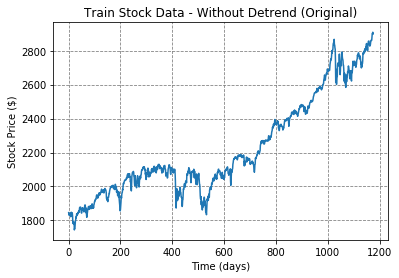

In [0]:
plt.plot(range(0, len(sp5_open_orig)), sp5_open_orig)
plt.xlabel('Time (days)')
plt.ylabel('Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Train Stock Data - Without Detrend (Original)')

###Relative performance of different RL Policy models on Train Data

Run the RL prediction through several loops for Train Data

####Define a function to predict for RL policy on a given stock data

In [0]:
def model_stock_data(model, sp5open, sp5close, policyName):

  global series_length
  env.reset()

  complete_game = False
  j = 0
  i = 0
  st = time.time()

  while not complete_game:
      bought_sp5_at = []
      sold_sp5_at = []

      bsp5_action_times = []
      ssp5_action_times = []
      n_action_times = []

      profit_sp5 = []

      starting_val = env.starting_portfolio_value
      j += 1
      for i in range(0,env.series_length + 1):
          action = model.act(env.state)
          if action == 2:
              n_action_times.append(env.cur_timestep)
          if action == 1:
              bought_sp5_at.append(sp5open[env.cur_timestep])
              bsp5_action_times.append(env.cur_timestep)
          if action == 0:
              sold_sp5_at.append(sp5close[env.cur_timestep])
              ssp5_action_times.append(env.cur_timestep)

          (next_state, reward, done, msg), st_val, gain = env.step(action)

          if msg["msg"] == 'bankrupted self':
              env.reset()
              break
          if msg["msg"] == 'sold more than have':
              env.reset()
              break
          if i < series_length:
              pr = env.portfolio_value() - st_val
              if action == 2:
                pr = 0                
              profit_sp5.append(pr)
          if i == series_length:
             complete_game = True
             break

  pr = torch.sum(torch.tensor(profit_sp5))


  return pr

####Plot policy comparisons on train data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Predicted Profit Metrics

Predicted Normalized Profit Metrics with respect to RNN Policy


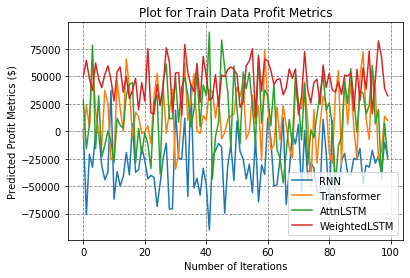

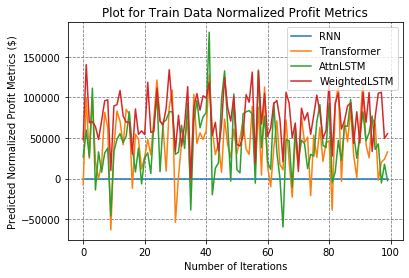

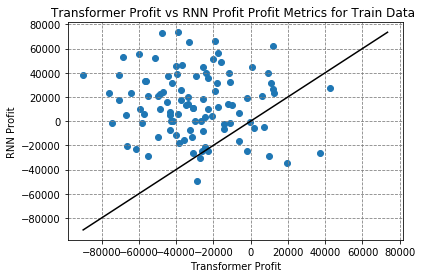

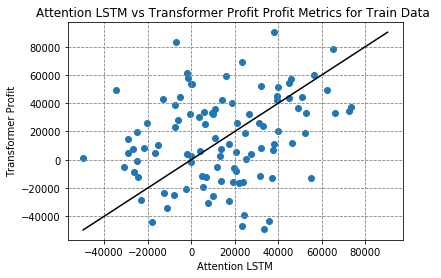

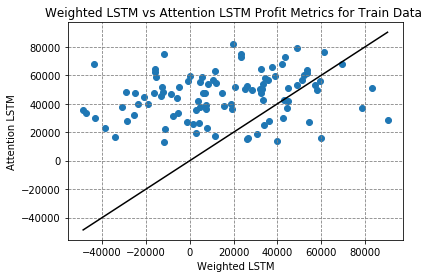


Running time = 4.5 min for 100.0 iters 
Running rate = 22.0 iters/min


In [0]:
def scat_plot(x, y, plt1, xlabel, ylabel, md):
  min_x = torch.min(x)
  min_y = torch.min(y)
  max_x = torch.max(x)
  max_y = torch.max(y)

  plt.scatter(x,y)
  xran = torch.arange(torch.min(min_x,min_y),torch.max(max_x,max_y))
  yran = xran.clone().detach()
  plt.plot(xran, yran, color = 'k')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(color='gray', linestyle='dashed')
  plt.title("%s vs %s Profit Metrics for %s Data " %(xlabel,ylabel,md))


def profit_plots(profit_rnn, profit_transf, profit_attnLSTM, profit_wtLSTM, md):

  nr_rnn = profit_rnn - profit_rnn
  nr_transf = profit_transf - profit_rnn
  nr_attnLSTM = profit_attnLSTM - profit_rnn
  nr_wtLSTM = profit_wtLSTM - profit_rnn

  print('\nPredicted Profit Metrics')

  plt.figure(1)

  #Plot profit results on stock data
  plt.plot(range(0, len(profit_rnn)), profit_rnn)
  plt.plot(range(0, len(profit_transf)), profit_transf)
  plt.plot(range(0, len(profit_attnLSTM)), profit_attnLSTM)
  plt.plot(range(0, len(profit_wtLSTM)), profit_wtLSTM)
  plt.xlabel('Number of Iterations')
  plt.ylabel('Predicted Profit Metrics ($)')
  plt.grid(color='gray', linestyle='dashed')
  plt.title("Plot for %s Data Profit Metrics" %(md))
  plt.legend(['RNN','Transformer','AttnLSTM','WeightedLSTM'])

  print('\nPredicted Normalized Profit Metrics with respect to RNN Policy')

  plt.figure(2)

  #Plot normalized profit results on stock data
  plt.plot(range(0, len(nr_rnn)), nr_rnn)
  plt.plot(range(0, len(nr_transf)), nr_transf)
  plt.plot(range(0, len(nr_attnLSTM)), nr_attnLSTM)
  plt.plot(range(0, len(nr_wtLSTM)), nr_wtLSTM)
  plt.xlabel('Number of Iterations')
  plt.ylabel('Predicted Normalized Profit Metrics ($)')
  plt.grid(color='gray', linestyle='dashed')
  plt.title("Plot for %s Data Normalized Profit Metrics" %(md))
  plt.legend(['RNN','Transformer','AttnLSTM','WeightedLSTM'])


  xlabel = ['RNN Profit', 'Transformer Profit',  'Attention LSTM',
            'Weighted LSTM']

  plt.figure(3)
  scat_plot(profit_rnn, profit_transf, plt1, xlabel[1],xlabel[0], md)
  plt.figure(4)
  scat_plot(profit_transf, profit_attnLSTM, plt2, xlabel[2],xlabel[1], md)
  plt.figure(5)
  scat_plot(profit_attnLSTM, profit_wtLSTM, plt3, xlabel[3],xlabel[2], md)
  plt.show()


#initialize environment with given shares and cash
# global max_stride
max_stride = 4
series_length = sp5_open_orig.size // max_stride - max_stride
starting_cash_mean = 15000
starting_shares_mean = 100

# %matplotlib inline
#Results on with detrend test data
env = initialize_env(sp5_open_orig, sp5_close_orig, series_length)

profit_rnn = torch.zeros(0)
profit_transf = torch.zeros(0)
profit_attnLSTM = torch.zeros(0)
profit_wtLSTM = torch.zeros(0)

st=time.time()
for i in np.arange(100):
    
    pr = model_stock_data(model.to(device), sp5_open_orig,
                      sp5_close_orig, 'RNN')

    profit_rnn = torch.cat((profit_rnn,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelT.to(device), sp5_open_orig,
                      sp5_close_orig, 'Transformer')
    profit_transf = torch.cat((profit_transf,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelAttnLSTM.to(device), sp5_open_orig,
                      sp5_close_orig, 'AttnLSTM')
    profit_attnLSTM = torch.cat((profit_attnLSTM,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelWeightLSTM.to(device), sp5_open_orig,
                      sp5_close_orig, 'WeightLSTM')
    profit_wtLSTM = torch.cat((profit_wtLSTM,pr.unsqueeze(0)),dim = 0)

profit_plots(profit_rnn, profit_transf, profit_attnLSTM, profit_wtLSTM, "Train")

et = (time.time() - st) / 60
print('\nRunning time = {:.1f} min for {:.1f} iters \nRunning rate = {:.1f} iters/min'.
      format(et, i+1, (i+1) / et))


###RL Model performance on (Original) Test Stock data

Performace on Test Stock data without detrend

####Plot Original Train Stock Data



                   Open         High  ...    Adj Close      Volume
Date                                  ...                         
2018-09-04  2896.959961  2900.179932  ...  2896.719971  3077060000
2018-09-05  2891.590088  2894.209961  ...  2888.600098  3241250000
2018-09-06  2888.639893  2892.050049  ...  2878.050049  3139590000
2018-09-07  2868.260010  2883.810059  ...  2871.679932  2946270000
2018-09-10  2881.389893  2886.929932  ...  2877.129883  2731400000

[5 rows x 6 columns]


Text(0.5, 1.0, 'Test Stock Data ')

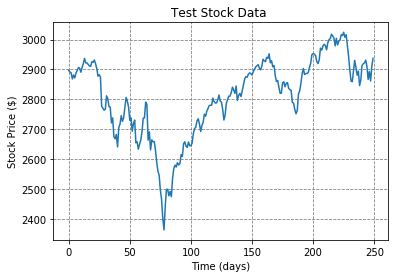

In [0]:
sp5tt_stock = test[:].copy()
sp5tt_open = test["Open"].values
sp5tt_close = test["Close"].values

print (sp5tt_stock.head())

plt.plot(range(0, len(sp5tt_open)), sp5tt_open)
plt.xlabel('Time (days)')
plt.ylabel('Stock Price ($)')
plt.grid(color='gray', linestyle='dashed')
plt.title('Test Stock Data ')

###Relative performance of different RL Policy models on Test Data

Run the RL prediction through several loops for Test Data

####Plot policy comparisons on test data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Predicted Profit Metrics

Predicted Normalized Profit Metrics with respect to RNN Policy


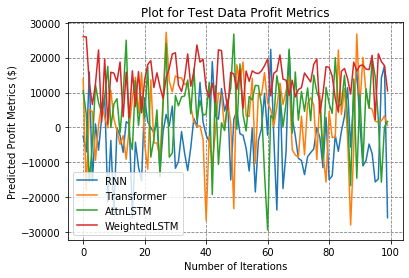

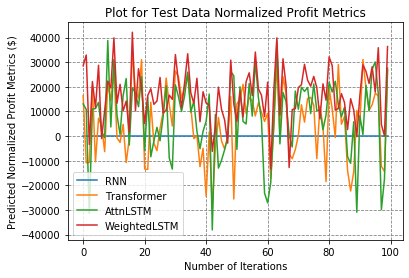

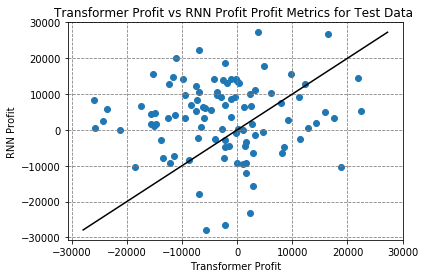

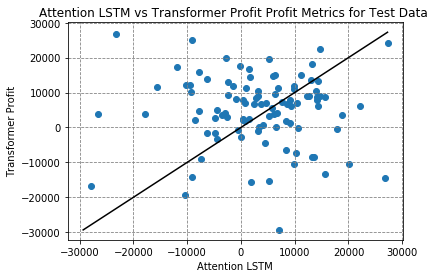

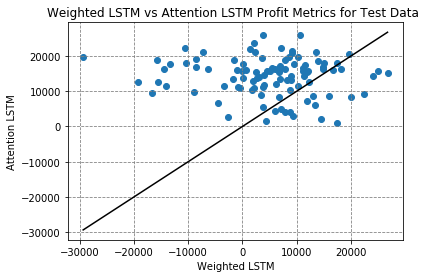


Running time = 0.9 min for 100.0 iters 
Running rate = 107.0 iters/min


In [0]:
#initialize environment with given shares and cash
# global max_stride
max_stride = 4
series_length = sp5tt_open.size // max_stride - max_stride
starting_cash_mean = 15000
starting_shares_mean = 100

# %matplotlib inline
#Results on with test data
env = initialize_env(sp5tt_open, sp5tt_open, series_length)

profit_rnn = torch.zeros(0)
profit_transf = torch.zeros(0)
profit_attnLSTM = torch.zeros(0)
profit_wtLSTM = torch.zeros(0)

st=time.time()
for i in np.arange(100):
    
    pr = model_stock_data(model.to(device), sp5tt_open,
                      sp5tt_close, 'RNN')

    profit_rnn = torch.cat((profit_rnn,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelT.to(device),sp5tt_open,
                      sp5tt_close, 'Transformer')
    profit_transf = torch.cat((profit_transf,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelAttnLSTM.to(device),sp5tt_open,
                      sp5tt_close, 'AttnLSTM')
    profit_attnLSTM = torch.cat((profit_attnLSTM,pr.unsqueeze(0)),dim = 0)

    pr = model_stock_data(modelWeightLSTM.to(device),sp5tt_open,
                      sp5tt_close, 'WeightLSTM')
    profit_wtLSTM = torch.cat((profit_wtLSTM,pr.unsqueeze(0)),dim = 0)


profit_plots(profit_rnn, profit_transf, profit_attnLSTM, profit_wtLSTM, 'Test')

et = (time.time() - st) / 60
print('\nRunning time = {:.1f} min for {:.1f} iters \nRunning rate = {:.1f} iters/min'.
      format(et, i+1, (i+1) / et))


# References

* https://gym.openai.com/

*   https://towardsdatascience.com/a-blundering-guide-to-making-a-deep-actor-critic-bot-for-stock-trading-c3591f7e29c2

*   Kim, Sangyeon, and Myungjoo Kang. "Financial series prediction using Attention LSTM." arXiv preprint arXiv:1902.10877 (2019)

* Tom Grek's code at https://github.com/tomgrek/RL-stocktrading/blob/master/Finance%20final.ipynkhl
